In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import pandas as pd
import numpy as np

import os
import warnings

from scipy.io import wavfile

from hmmlearn import hmm  
import pomegranate

from python_speech_features import mfcc

from sklearn.externals import joblib

import hmm_model_feature_extraction

import random

import matplotlib.pyplot as plt

from tqdm import tqdm

from ast import literal_eval

from google.cloud import storage

# affects whether to configure to running on the cloud
gcp = True
# affects whether to pull files from gcs or locally
use_files_locally = True

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
if gcp == True:
    
    import gcsfs
    import pickle
    import cupy
    
    # specify gcs bucket
    bucket_name = "ad-bucket-15730"
    # set cloud based mixed dir
    gcs_mixed_dir = "gs://{}/mixed_20k".format(bucket_name)
    # set cloud based hmm model dir
    gcs_hmm_model_dir = "gs://{}/hmm_models".format(bucket_name)
    # set cloud based validation dir
    gcs_validation_dir = "gs://{}/validation".format(bucket_name)
    # set local, vm-based mixed dir
    local_mixed_dir = "mixed_local"
    # set local, vm-based validation dir
    local_validation_dir = "validation_local"
    # initialize gcsfs object
    fs = gcsfs.GCSFileSystem(project = 'audio-detection-1')

    # enable gpus for pomegranate
    pomegranate.utils.enable_gpu()
    print("communicating with GPU: ", pomegranate.utils.is_gpu_enabled())
    
    ### moving pre-populated validation and training set ###
    ### for faster model validation ###
    
    # need to create folder on vm instance for validation set
    if "validation_local" not in os.listdir():
        
        os.mkdir("validation_local")
        
    # need to create folder on vm instance for training (mixed) set 
    if "mixed_local" not in os.listdir():
        
        os.mkdir("mixed_local")
        
    # if fewer then ten (arbitrary) files, copy all in from gcs   
    if len(os.listdir("validation_local")) < 10:
        
        os.system("gsutil -m cp {}/* ./{}".format(gcs_validation_dir, local_validation_dir))
        
    # if fewer then ten (arbitrary) files, copy all in from gcs    
    if len(os.listdir("mixed_local")) < 10:
        
        os.system("gsutil -m cp {}/* ./{}".format(gcs_mixed_dir, local_mixed_dir))    
        
else:
    
    # configuration when not running on the cloud
    mixed_dir = "../../../mixed"
    hmm_model_dir = "../../../hmm_models"

communicating with GPU:  True


In [3]:
### name this particular trial ###
# will change for each trial
trial_name = "52G-RAM_20kHz_13CC_multi-dim_multi-state_200-iter_2-thread"

### initialize feature extraction class ###
# mixed_dir will depend on whether we are pulling from gcs or locally
# sampling_freq will depend on how we initially processed our audio files
# gcs will depend on whether we want to pull from gcs during training or from local directory
fe = hmm_model_feature_extraction.feature_extraction(mixed_dir="mixed_local", sampling_freq = 20000, gcs = False)

### load in mixed_metadata ###
metadata = pd.read_csv(gcs_mixed_dir + "/mixed_metadata.csv")

### max number of iterations the E-M algorithm performs during training ### 
num_iterations = 200

### number of cepstral coefficients to return from mfcc (13 is default) ###
num_cep_coefs = 13

### whether we will feed concatenated, 2-dimensional cepstral coefficients for each track as a sample ###
multidimensional_input = True

### whether to use the pomegranate package or hmmlearn for fitting hmm ###
use_pomegranate = True

### what distribution to use for the hidden states ###
distribution = pomegranate.MultivariateGaussianDistribution



In [4]:
# re-configuring metadata df if we're using on the cloud given the set-aside validation set:

if gcp == True:
    
    # get list of validation sample files
    validation_samples_list = os.listdir("validation_local")
    # pull just the validation samples from the metadata df
    validation_df = metadata[metadata['slice_file_name'].isin(validation_samples_list)]
    # convert validation_df to list of tuples
    validation_samples = [(validation_df['slice_file_name'].iloc[i], validation_df['class'].iloc[i]) for i in range(len(validation_df))]
    # retain only the training samples in the metadata df 
    metadata = metadata[~metadata['slice_file_name'].isin(validation_samples_list)]

In [5]:
metadata.shape

(20957, 8)

In [6]:
# choose hidden states per self-organizing maps

label_states = pd.Series({"air_conditioner":20, "car_horn":18, "children_playing":11,
             "dog_bark":17, "drilling":20, "engine_idling":20,
             "gun_shot":9, "jackhammer":18, "siren":17,
             "street_music":17})

399


Text(0.5, 1.05, 'MFCC')

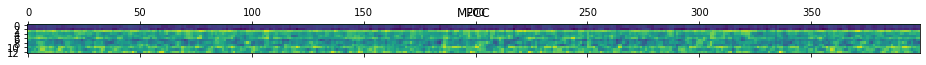

In [7]:
# test data intake

time_signal = fe.read("100852-0-0-13.wav")
mfccs = fe.return_mfcc(time_signal, nfft=1200)
print(mfccs.shape[0])
plt.matshow(mfccs.T)
plt.title('MFCC')

In [8]:
### Define a class to train the HMM ###

# Parameters of `hmm.GaussianHMM()`:
# `n_components`: number of states of HMM
# `covariance_type`: type of covariance matrix for each state. 
# Each state is a random vector. 
# This parameter is a string defining the type of covariance matrix of this vector. Defaults to `"diagonal"`

class HMM_Model(object):
    
    def __init__(self, num_components=12, 
                 num_iter=100,
                use_pomegranate=True,
                distribution=pomegranate.NormalDistribution,
                gpu=False):
        
        self.n_components = num_components
        self.n_iter = num_iter
        self.use_pomegranate = use_pomegranate
        self.distribution = distribution
        
        # define the covariance type and the type of HMM:
        self.cov_type = 'diag'
        self.model_name = 'GaussianHMM'
        
        # initialize the variable in which we will store the models for each word:
        self.models = []
        
        # define the model using the specified parameters:
        if not self.use_pomegranate:

            self.model = hmm.GaussianHMM(n_components=self.n_components,
                                     covariance_type=self.cov_type,
                                     n_iter=self.n_iter, verbose=True)
        
        # we anble pomegranate's gpu utility if gpu is set to true 
        self.gpu = gpu
        if self.gpu==True:
            
            pomegranate.utils.enable_gpu()
            print("pomegranate_gpu is enabled: ", pomegranate.utils.is_gpu_enabled())
            
        else:
            
            pomegranate.utils.disable_gpu()
            print("pomegranate_gpu is enabled: ", pomegranate.utils.is_gpu_enabled())
            

    def train(self, training_data, multidimensional_input, n_threads):
        
        """
        Defines a method to train the model
        'training_data' is a 2D numpy array where each row has the 
        length of number of mfcc coefficients
        """
        # for default case using pomegranate package        
        if self.use_pomegranate:
            
            # training on multidimensional input (i.e. n_samples x n_windows x n_cepstral_coefs)
            if multidimensional_input:
                
                print("training on multidimensional input using pomegranate, {} states, {} iterations, sample shape {}, and {} threads".format(self.n_components,self.n_iter,training_data.shape, n_threads))
                self.model = pomegranate.HiddenMarkovModel.from_samples(self.distribution, 
                                                                    self.n_components,
                                                                    training_data, 
                                                                    max_iterations=self.n_iter,
                                                                    stop_threshold = 1e-3,
                                                                    algorithm="baum-welch", 
                                                                    n_jobs=n_threads, 
                                                                    verbose=True)
            
            # training on unidimensional input (i.e. one cepstral grid per track)
            else:
                
                print("training on unidimensional input using pomegranate, {} states, {} iterations, sample shape {}, and {} threads".format(self.n_components,self.n_iter,training_data.shape, n_threads))
                self.model = pomegranate.HiddenMarkovModel.from_samples(self.distribution, 
                                                                    self.n_components,
                                                                    training_data, 
                                                                    max_iterations=self.n_iter, 
                                                                    stop_threshold = 1e-3,    
                                                                    algorithm="baum-welch", 
                                                                    n_jobs=n_threads, 
                                                                    verbose=True)
                
                
            self.models.append(self.model)
        
        # for alternative case using hmmlearn
        else:
            
            print("training on unidimensional input using pomegranate, {} states, {} iterations, and sample shape {}".format(self.n_components,self.n_iter,training_data.shape))
            np.seterr(all='ignore')
            cur_model = self.model.fit(training_data)
            self.models.append(cur_model)

    
    def compute_score(self, input_data):
        
        """
        Define a method to compute log likelihood score for input features
        Returns: Log likelihood of sample input_data
        """
        if self.use_pomegranate:
            print("scoring input of shape ", input_data.shape, " using pomegranate")
            return self.model.log_probability(input_data)
            
        else:
            print("scoring input of shape ", input_data.shape, " hmmlearn")
            return self.model.score(input_data)

In [9]:
def build_one_model(features_vector, num_states, num_iterations, multidimensional_input, \
                    use_pomegranate, distribution, gpu, n_threads):
    
    """
    features_vector: nparray of features from Class above
    num_states: number of hidden states in HMM
    """
    
    # initiate HMM model object
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model = HMM_Model(num_components=num_states, num_iter=num_iterations, 
                          use_pomegranate=use_pomegranate, distribution=distribution, gpu=gpu)

    # train HMM model, calculate likelihood of the sample by the trained model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model.train(features_vector, multidimensional_input, n_threads)
        model_score = model.compute_score(features_vector)
        
    return model, model_score

In [10]:
def hmm_aic(LLik, n, k):
    
    """
    Takes in loglikelihood of trained HMM plus number of params
    Returns: Model AIC
    """
    return -2*LLik+2*(n*n+k*n-1)

In [11]:
def build_all_models(label_name, metadata, num_states, num_iterations, training_prop = 0.7, \
                     multidimensional_input=False, use_pomegranate=True, \
                     distribution = pomegranate.NormalDistribution, gpu=False, n_threads = 2):
    
    """
    Given an input data folder with subfolders for each response label
    """
    
    # empty list for storing model results
    model_results = []
    validation_set = []
    

    # load in filenames relevant to a particular label
    label_file_names = metadata[metadata['class'] == label_name]['slice_file_name'].tolist()
    # reserve 30 percent for validation
    num_to_train = int(np.ceil(len(label_file_names) * training_prop)) # may need to reduce for pomegranate training
    train = random.sample(label_file_names, num_to_train)
    print(label_name,"train length:", len(train))
    validate = list(set(label_file_names) - set(train))
    print(label_name," validation length:", len(validate))
    # append the list of validation filenames and respective label to validation_set
    validation_set.append((validate, label_name))
    
    # for unidimensional inputs
    if multidimensional_input == False:
    
        # create an empty array for appending features
        X = np.array([])
    
        print("loading in files for label: ", label_name)

        for j in tqdm(range(len(train))):
        
            loaded = fe.read(train[j])
            # nfft assumes 44100Hz
            mfcc_features = fe.return_mfcc(loaded, nfft=1200)

            if len(X) == 0:
                
                X = mfcc_features
            
            else:
                
                X = np.append(X, mfcc_features, axis=0)
            
        model = build_one_model(X, num_states, num_iterations, multidimensional_input, \
                                use_pomegranate, distribution, gpu, n_threads)
        
        # add the model to the results list
        model_results.append((model, label_name))
        
        # reset model variable
        model = None

        return model_results, validation_set
    
    # for multidimensional inputs
    else:
        
        # create an empty array for appending features
        X = np.array([])
    
        print("loading in files for label: ", label_name)
        
        # need to count the number of samples not discarded
        counter = 0
        for j in tqdm(range(len(train))):
        
            loaded = fe.read(train[j])
            # nfft assumes 44100Hz
            mfcc_features = fe.return_mfcc(loaded, nfft=1200)
            
            # need to have all mfcc features the same 
            if mfcc_features.shape[0] == 399: # this number likely not robust to other sampling rates

                if len(X) == 0:
                
                    X = mfcc_features
                    counter += 1
            
                else:
                
                    X = np.append(X, mfcc_features, axis=0)
                    counter += 1
                    
            else:
                
                pass
        
        # (n_samples x n_windows x n_cepstral_coefs)
        X = X.reshape(counter, 399, num_cep_coefs) # this number likely not robust to other sampling rates
        model = build_one_model(X, num_states, num_iterations, multidimensional_input, \
                                use_pomegranate, distribution, gpu, n_threads)
        
        # add the model to the results list
        model_results.append((model, label_name))
        
        # Reset model variable
        model = None

        return model_results, validation_set
                
                
        
        
        


In [ ]:
"""
Initiate Training
"""

# empty list to which to append fitted hmms and validation sets

models, validation_sample = [],[]

# loop through each of the labels
for i in range(len(label_states.index)):
    
    # extract the label name
    label_name = label_states.index[i]
    # extract corresponding chosen number of states
    num_states = label_states[label_states.index[i]]
    
    # send through model build functions
    ### we make training_prop = 1 when on the cloud ###
    model_results, validation_set = build_all_models(label_name, metadata, num_states, num_iterations, \
                                                     training_prop = 0.5, \
                                                     multidimensional_input = multidimensional_input, \
                                                     use_pomegranate = use_pomegranate, \
                                                     distribution = distribution, \
                                                    gpu=False, n_threads = 3)
    models.append(model_results)
    validation_sample.append(validation_set)
    

  0%|          | 3/1192 [00:00<00:40, 29.43it/s]

air_conditioner train length: 1192
air_conditioner  validation length: 1192
loading in files for label:  air_conditioner


100%|██████████| 1192/1192 [00:50<00:00, 23.51it/s]


pomegranate_gpu is enabled:  False
training on multidimensional input using pomegranate, 20 states, 200 iterations, sample shape (1188, 399, 13), and 3 threads
[1] Improvement: 1223933.362303637	Time (s): 18.77
[2] Improvement: 185069.27167219296	Time (s): 19.86
[3] Improvement: 75968.18989887834	Time (s): 20.03
[4] Improvement: 39753.262379903346	Time (s): 19.09


In [1]:
models

NameError: name 'models' is not defined

In [ ]:
# format validation_sample outputs for validation, only if not using the set-aside validation set

if gcp == False:
    
    validation_samples = [(validation_sample[0][0][0][i],validation_sample[0][0][1]) for i in range(len(validation_sample[0][0][0]))] + \
[(validation_sample[1][0][0][i],validation_sample[1][0][1]) for i in range(len(validation_sample[1][0][0]))] + \
[(validation_sample[2][0][0][i],validation_sample[2][0][1]) for i in range(len(validation_sample[2][0][0]))] + \
[(validation_sample[3][0][0][i],validation_sample[3][0][1]) for i in range(len(validation_sample[3][0][0]))] + \
[(validation_sample[4][0][0][i],validation_sample[4][0][1]) for i in range(len(validation_sample[4][0][0]))] + \
[(validation_sample[5][0][0][i],validation_sample[5][0][1]) for i in range(len(validation_sample[5][0][0]))] + \
[(validation_sample[6][0][0][i],validation_sample[6][0][1]) for i in range(len(validation_sample[6][0][0]))] + \
[(validation_sample[7][0][0][i],validation_sample[7][0][1]) for i in range(len(validation_sample[7][0][0]))] + \
[(validation_sample[8][0][0][i],validation_sample[8][0][1]) for i in range(len(validation_sample[8][0][0]))] + \
[(validation_sample[9][0][0][i],validation_sample[9][0][1]) for i in range(len(validation_sample[9][0][0]))]

In [28]:
# save validation_sample to txt 

if use_files_locally == True and gcp == True:

    with open(local_validation_dir + '/validation_samples_{}.txt'.format(trial_name),'w') as file:
    
        for ele in validation_samples:
        
            file.write(str(ele)+'\n')
    
        file.close()
        
elif use_files_locally == True and gcp == False:
    
    with open(hmm_model_dir + '/validation_samples_{}.txt'.format(trial_name),'w') as file:
    
        for ele in validation_samples:
        
            file.write(str(ele)+'\n')
    
        file.close()
         
else:
    
    with fs.open(gcs_hmm_model_dir + '/validation_samples_{}.txt'.format(trial_name),'w') as file:
    
    for ele in validation_samples:
        
        file.write(str(ele) + "\n")
    
    file.close()
    
    
    

In [ ]:
# model save to pkl

if gcp == True:

    with fs.open('ad-bucket-15730/hmm_models/model_{}.pkl'.format(trial_name), 'wb') as file:
        pickle.dump(models, file)
        
else:
    
    joblib.dump(models,hmm_model_dir+'/model_{}.pkl'.format(trial_name))
    